# $\alpha$-DSBM implmentation

In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader

np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [39]:
eps = 0.1                   # Entropic regularization parameter
alpha_step = 1e-3           # Gradient scaling for incremental update
pretrain_steps = 1000       # Number of steps for pretraining
finetune_steps = 9000       # Number of steps for finetuning
batch_size = 256            # Batch size for training
ema_decay = 0.9             # EMA decay rate
dataset_size_pi0 = 1000     # Number of samples from source distribution
dataset_size_pi1 = 1000     # Number of samples from target distribution
hidden_dim = 256            # Number of nodes in hidden layer of drift network

# Mixture parameters for source and target distributions
pi0_params = [
    (0.5, [-4, -4], torch.tensor([[1.0, -0.5], [-0.5, 1.0]], device=device)),
    (0.5, [-4, 4], torch.tensor([[1.0, -0.5], [-0.5, 1.0]], device=device))
]
pi1_params = [
    (0.5, [4, -4], torch.tensor([[1.0, 0.5], [0.5, 1.0]], device=device)),
    (0.5, [4, 4], torch.tensor([[1.0, 0.5], [0.5, 1.0]], device=device))
]

In [40]:
# ============================================================
# 1. Data Sampling 
# ============================================================
def sample_mixture(dist_params, batch_size):
    """
    dist_params: list of tuples (weight, mean, cov)
    For simplicity, we assume covariances are provided (as torch tensors) and are constant.
    """
    weights = np.array([w for w, m, cov in dist_params])
    comp = np.random.choice(len(dist_params), size=batch_size, p=weights/weights.sum())
    samples = []
    for idx in comp:
        _, mean, _ = dist_params[idx]
        sample = torch.randn(1, 2, device=device) + torch.tensor(mean, device=device)
        samples.append(sample)
    return torch.cat(samples, dim=0)

def sample_pi0_dataset(N, params):
    return sample_mixture(params, N)

def sample_pi1_dataset(N, params):
    return sample_mixture(params, N)
    
def mixture_density(x, dist_params):
    """
    Compute density at x for a mixture (assuming identity covariance)
    x: shape (N,2)
    Returns: density values (N,)
    """
    dens = np.zeros(x.shape[0])
    for w, mean, cov in dist_params:
        if isinstance(mean, torch.Tensor):
            mean = mean.cpu().numpy()
        if isinstance(cov, torch.Tensor):
            cov = cov.cpu().numpy()
        diff = np.array(x - mean)
        inv_cov = np.linalg.inv(cov)
        det_cov = np.linalg.det(cov)
        norm_const = 1.0 / (2 * np.pi * np.sqrt(det_cov))
        exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
        dens += w * norm_const * np.exp(exponent)
    return dens

# Fixed datasets
class DistributionDataset(Dataset):
    def __init__(self, N, params, sampler_fn, device):
        with torch.no_grad():
            self.x = sampler_fn(N, params).to(device)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx]

def build_loader(N, params, sampler_fn, batch_size, device, shuffle=True):
    ds = DistributionDataset(N, params, sampler_fn, device)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=True)

# ============================================================
# 2. Brownian Bridge Interpolant (Interp operator)
# ============================================================
def interp(x0, x1, t, eps=1.0):
    """
    Returns the Brownian bridge interpolation:
      x_t = (1-t)*x0 + t*x1 + sqrt(eps*t*(1-t))*z,
    with z ~ N(0,I)
    """
    x_linear = (1 - t) * x0 + t * x1
    noise_std = torch.sqrt(eps * t * (1 - t))
    z = torch.randn_like(x0)
    return x_linear + noise_std * z

# ============================================================
# 3. Bidirectional Drift Network v_theta(s, t, x)
# ============================================================
class BidirectionalDriftNet(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=2):
        """
        Input: concatenation of s (direction, forward=1, backward=0), t (time), and x (2D point).
        """
        super(BidirectionalDriftNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, s, t, x):
        if t.dim() == 1:
            t = t.unsqueeze(1)
        inp = torch.cat([s, t, x], dim=1)  # shape [B,4]
        return self.net(inp)

# ============================================================
# 4. EMA Update Function
# ============================================================
def update_ema(model, ema_model, decay):
    with torch.no_grad():
        msd = model.state_dict()
        esd = ema_model.state_dict()
        for key in msd.keys():
            esd[key].mul_(decay).add_(msd[key] * (1 - decay))
        ema_model.load_state_dict(esd)

# ============================================================
# 5. Loss Functions with Loss Scaling (Bidirectional)
# ============================================================
def compute_bidirectional_loss(model, x0, x1, t, eps=1.0):
    # Forward branch (s=1)
    x_t = interp(x0, x1, t, eps)
    s_f = torch.ones_like(t, device=device)
    v_f = model(s_f, t, x_t)
    target_f = (x1 - x_t) / (1 - t)
    weight_fwd = 1 / (1 + eps * t / (1 - t + 1e-6))    # more stable for t close to 1
    
    # Backward branch (s=0) - swap endpoints
    # x_t_b = interp(x0, x1, t, eps)
    s_b = torch.zeros_like(t, device=device)
    v_b = model(s_b, t, x_t)
    target_b = (x0 - x_t) / t
    weight_bwd = 1 / (1 + eps * (1 - t) / (t + 1e-6))  # more stable for t close to 0
    
    loss_forward = (weight_fwd * ((v_f - target_f)**2)).mean()
    loss_backward = (weight_bwd * ((v_b - target_b)**2)).mean()
    return 0.5 * (loss_forward + loss_backward)

# ============================================================
# 6. Pretraining Stage
# ============================================================
def pretraining_stage(model, ema_model, dl_pi0, dl_pi1, num_steps=5000, eps=1.0, lr=1e-3, ema_decay=0.9):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_hist = []
    it0, it1 = iter(dl_pi0), iter(dl_pi1)
    for step in range(num_steps):
        try:    x0 = next(it0)
        except StopIteration:
            it0 = iter(dl_pi0); x0 = next(it0)
        try:    x1 = next(it1)
        except StopIteration:
            it1 = iter(dl_pi1); x1 = next(it1)
        t = torch.rand(x0.shape[0], 1, device=device)
        loss = compute_bidirectional_loss(model, x0, x1, t, eps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        update_ema(model, ema_model, ema_decay)
        loss_hist.append(loss.item())
        if (step+1) % 1000 == 0:
            print(f"[Pretraining] Step {step+1}/{num_steps}, Loss: {loss.item():.4f}")
    return loss_hist

# ============================================================
# 7. Finetuning Stage (Online Bidirectional Updates with SDE propagation)
# ============================================================
def euler_step(x, drift, dt):
    return x + drift * dt

def euler_maruyama_step(x, drift, dt, eps):
    noise = torch.randn_like(x) * np.sqrt(dt)
    return x + drift * dt + torch.sqrt(torch.tensor(eps, device=x.device)) * noise

def sample_forward_SDE(model, x0, num_steps=100, eps=1.0):
    """
    Simulate the forward SDE from x0 using Euler–Maruyama.
    SDE: dx = v_theta(1,t,x)*dt + sqrt(eps)*dB_t.
    Returns hat_x1.
    """
    dt = 1.0 / (num_steps - 1)
    x = x0.clone()
    s_val = torch.ones(x.shape[0], 1, device=device)  # forward: s=1
    ts = torch.linspace(0.0, 1.0, num_steps, device=device).view(-1, 1)
    for t in ts[:-1]:
        drift = model(s_val, t.expand(x.shape[0], 1), x)
        x = euler_maruyama_step(x, drift, dt, eps)
    return x

def sample_backward_SDE(model, x1, num_steps=100, eps=1.0):
    """
    Simulate the backward SDE from x1 using Euler–Maruyama.
    SDE: dx = v_theta(0,t,x)*dt + sqrt(eps)*dB_t, with time reversed.
    Returns hat_x0.
    """
    dt = 1.0 / (num_steps - 1)
    x = x1.clone()
    s_val = torch.zeros(x.shape[0], 1, device=device)  # backward: s=0
    ts = torch.linspace(1.0, 0.0, num_steps, device=device).view(-1, 1)
    for t in ts[:-1]:
        drift = model(s_val, t.expand(x.shape[0], 1), x)
        x = euler_maruyama_step(x, drift, dt, eps)
    return x

def finetuning_stage(model, ema_model, dl_pi0, dl_pi1, num_finetune_steps=5000, eps=1.0, lr=1e-4,
                     alpha_step=1e-3, ema_decay=0.9, save_freq=1000):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_hist = []
    saved_models = [deepcopy(ema_model.state_dict())]
    it0, it1 = iter(dl_pi0), iter(dl_pi1)
    for step in range(num_finetune_steps):
        # Sample endpoints from datasets
        try:    x0 = next(it0)
        except StopIteration:
            it0 = iter(dl_pi0); x0 = next(it0)
        try:    x1 = next(it1)
        except StopIteration:
            it1 = iter(dl_pi1); x1 = next(it1)
        
        # Propagate endpoints via SDEs:
        hat_x1 = sample_forward_SDE(model, x0, num_steps=100, eps=eps)
        hat_x0 = sample_backward_SDE(model, x1, num_steps=100, eps=eps)
        
        # For the forward branch:
        t_forward = torch.rand(x0.shape[0], 1, device=device)
        x_t_forward = interp(hat_x0, x1, t_forward, eps)
        s_forward = torch.ones_like(t_forward, device=device)  # s=1 for forward branch
        v_forward = model(s_forward, t_forward, x_t_forward)
        target_forward = (x1 - x_t_forward) / (1 - t_forward)
        weight_forward = 1 / (1 + eps * t_forward / (1 - t_forward + 1e-6))
        
        # For the backward branch:
        # Interpolate between hat_x0 and x1 (use refined source from backward SDE)
        t_backward = torch.rand(x0.shape[0], 1, device=device)
        x_t_backward = interp(x0, hat_x1, t_backward, eps)
        s_backward = torch.zeros_like(t_backward, device=device)  # s=0 for backward branch
        v_backward = model(s_backward, t_backward, x_t_backward)
        target_backward = (x0 - x_t_backward) / t_backward
        weight_backward = 1 / (1 + eps * (1 - t_backward) / (t_backward + 1e-6))
        
        loss_forward = (weight_forward * ((v_forward - target_forward)**2)).mean()
        loss_backward = (weight_backward * ((v_backward - target_backward)**2)).mean()
        loss = 0.5 * (loss_forward + loss_backward)
        
        optimizer.zero_grad()
        loss.backward()
        for param in model.parameters():
            param.grad.data.mul_(alpha_step)
        optimizer.step()
        update_ema(model, ema_model, ema_decay)
        loss_hist.append(loss.item())
        
        if (step+1) % save_freq == 0:
            print(f"[Finetuning] Step {step+1}/{num_finetune_steps}, Loss: {loss.item():.4f}")
        if (step+1) % save_freq == 0:    
            saved_models.append(deepcopy(ema_model.state_dict()))
            
    return loss_hist, saved_models

# ============================================================
# 8. Visualization: Plotting Saved Trajectories
# ============================================================
def sample_trajectory_bidirectional(model, s_value, x_init, num_steps=50, eps=1.0, use_noise=True):
    """
    Simulate a trajectory using Euler-Maruyama (if use_noise is True) or deterministic Euler (if False).
    s_value: tensor of shape [B,1] (1 for forward, 0 for backward).
    x_init: starting point tensor of shape [B,2]
    """
    ts = torch.linspace(0.0, 1.0, num_steps, device=device).view(-1, 1)  # shape [num_steps,1]
    dt = 1.0 / (num_steps - 1)
    trajectory = []
    x = x_init.clone()  # starting point
    trajectory.append(x.detach().cpu().numpy())  # store as numpy array
    with torch.no_grad():
        for t in ts[:-1]:
            drift = model(s_value, t.expand(x.shape[0], 1), x)
            if use_noise:
                x = euler_maruyama_step(x, drift, dt, eps)
            else:
                x = euler_step(x, drift, dt)
            trajectory.append(x.detach().cpu().numpy())
    # Concatenate along the time dimension (resulting shape: [num_steps, 2])
    traj = np.concatenate(trajectory, axis=0)
    return traj

def plot_saved_trajectories(saved_models, model, x0_pool, x1_pool, hidden_dim=256, num_steps=50, eps=1.0, num_traj=3, use_ema=True):
    idx0_all = torch.randint(0, x0_pool.shape[0], (num_traj,), device=device)
    idx1_all = torch.randint(0, x1_pool.shape[0], (num_traj,), device=device)
    x0_pts = x0_pool[idx0_all]   # shape [num_traj, 2]
    x1_pts = x1_pool[idx1_all]   # shape [num_traj, 2]
    traj_dict = {}
    for i, state in enumerate(saved_models):
        net = BidirectionalDriftNet(input_dim=4, hidden_dim=hidden_dim, output_dim=2).to(device)
        net.load_state_dict(state)
        net.eval()
        traj_fwd_list = []
        traj_bwd_list = []
        for j in range(num_traj):
            x0_sample = x0_pts[j].unsqueeze(0)  # shape [1,2]
            x1_sample = x1_pts[j].unsqueeze(0)  # shape [1,2]
            
            traj_fwd = sample_trajectory_bidirectional(net, torch.ones(1,1, device=device), x0_sample, num_steps, eps, use_noise=False)
            traj_bwd = sample_trajectory_bidirectional(net, torch.zeros(1,1, device=device), x1_sample, num_steps, eps, use_noise=False)
            traj_fwd_list.append(traj_fwd)
            traj_bwd_list.append(traj_bwd)
        traj_dict[i] = {"forward": traj_fwd_list, "backward": traj_bwd_list}
    return traj_dict

def plot_trajectories_saved(traj_dict, x0_pool, x1_pool, nrows, save_freq, max_bg=500):
    x = np.linspace(-8, 8, 200)
    y = np.linspace(-8, 8, 200)
    X, Y = np.meshgrid(x, y)
    grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)
    pi0_density = mixture_density(grid_points, pi0_params).reshape(X.shape)
    pi1_density = mixture_density(grid_points, pi1_params).reshape(X.shape)

    x0_np = x0_pool.detach().cpu().numpy()
    x1_np = x1_pool.detach().cpu().numpy()
    if x0_np.shape[0] > max_bg:
        idx = np.random.choice(x0_np.shape[0], size=max_bg, replace=False)
        x0_np = x0_np[idx]
    if x1_np.shape[0] > max_bg:
        idx = np.random.choice(x1_np.shape[0], size=max_bg, replace=False)
        x1_np = x1_np[idx]
    
    num_saved = len(traj_dict)
    ncols = (num_saved + nrows - 1) // nrows
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
    axs = np.array(axs).flatten()
    
    for i in range(num_saved):
        ax = axs[i]
        ax.contour(X, Y, pi0_density, levels=10, cmap='Reds', alpha=0.5)
        ax.contour(X, Y, pi1_density, levels=10, cmap='Blues', alpha=0.5)
        ax.scatter(x0_np[:,0], x0_np[:,1], s=4, alpha=0.15, label='pi0 data', color='red')
        ax.scatter(x1_np[:,0], x1_np[:,1], s=4, alpha=0.15, label='pi1 data', color='blue')
        for traj in traj_dict[i]["forward"]:
            labels = ax.get_legend_handles_labels()[1]
            label = "Forward" if "Forward" not in labels else ""
            ax.plot(traj[:, 0], traj[:, 1], 'k--', alpha=0.5, lw=1, label=label)
            ax.scatter(traj[0, 0], traj[0, 1], color='red', s=20, alpha = 0.4)
            ax.scatter(traj[-1, 0], traj[-1, 1], color='blue', s=20, alpha = 0.4)
        for traj in traj_dict[i]["backward"]:
            labels = ax.get_legend_handles_labels()[1]
            label = "Backward" if "Backward" not in labels else ""
            ax.plot(traj[:, 0], traj[:, 1], 'g--', alpha=0.5, lw=1, label=label)
            ax.scatter(traj[0, 0], traj[0, 1], color='blue', s=20, alpha = 0.4)
            ax.scatter(traj[-1, 0], traj[-1, 1], color='red', s=20, alpha = 0.4)
        if(i==0):
            ax.set_title(f"Saved EMA Model after Pretraining Steps")
        else: 
            ax.set_title(f"Saved EMA Model at Finetuning Step {(i)*save_freq}")
        ax.legend()
        ax.grid(True)
    
    for j in range(num_saved, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [41]:
# Instantiate the bidirectional drift network and create its EMA copy.
model = BidirectionalDriftNet(input_dim=4, hidden_dim=hidden_dim, output_dim=2).to(device)
ema_model = BidirectionalDriftNet(input_dim=4, hidden_dim=hidden_dim, output_dim=2).to(device)
ema_model.load_state_dict(model.state_dict())

dl_pi0 = build_loader(dataset_size_pi0, pi0_params, sample_pi0_dataset, batch_size, device, shuffle=True)
dl_pi1 = build_loader(dataset_size_pi1, pi1_params, sample_pi1_dataset, batch_size, device, shuffle=True)

----- Pretraining Stage -----
[Pretraining] Step 1000/1000, Loss: 7.4600
----- Finetuning Stage -----
[Finetuning] Step 1000/9000, Loss: 0.3755
[Finetuning] Step 2000/9000, Loss: 0.2695
[Finetuning] Step 3000/9000, Loss: 0.2581
[Finetuning] Step 4000/9000, Loss: 0.2642
[Finetuning] Step 5000/9000, Loss: 0.3073
[Finetuning] Step 6000/9000, Loss: 0.2678
[Finetuning] Step 7000/9000, Loss: 0.2560
[Finetuning] Step 8000/9000, Loss: 0.2659
[Finetuning] Step 9000/9000, Loss: 0.2565


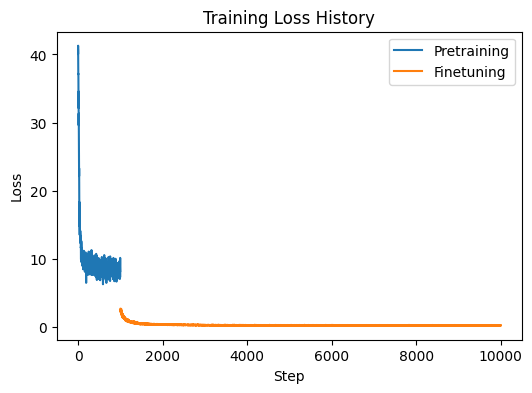

In [42]:
print("----- Pretraining Stage -----")
pretrain_loss = pretraining_stage(model, ema_model, dl_pi0, dl_pi1, num_steps=pretrain_steps, 
                                  eps=eps, lr=1e-3, ema_decay=ema_decay)
print("----- Finetuning Stage -----")
finetune_loss, saved_models = finetuning_stage(model, ema_model, dl_pi0, dl_pi1,
                                               num_finetune_steps=finetune_steps, eps=eps, lr=1e-4, 
                                               alpha_step=alpha_step, ema_decay=ema_decay, save_freq=1000)

# Plot training loss history
plt.figure(figsize=(6,4))
plt.plot(pretrain_loss, label="Pretraining")
plt.plot(np.arange(len(pretrain_loss), len(pretrain_loss)+len(finetune_loss)), finetune_loss, label="Finetuning")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()

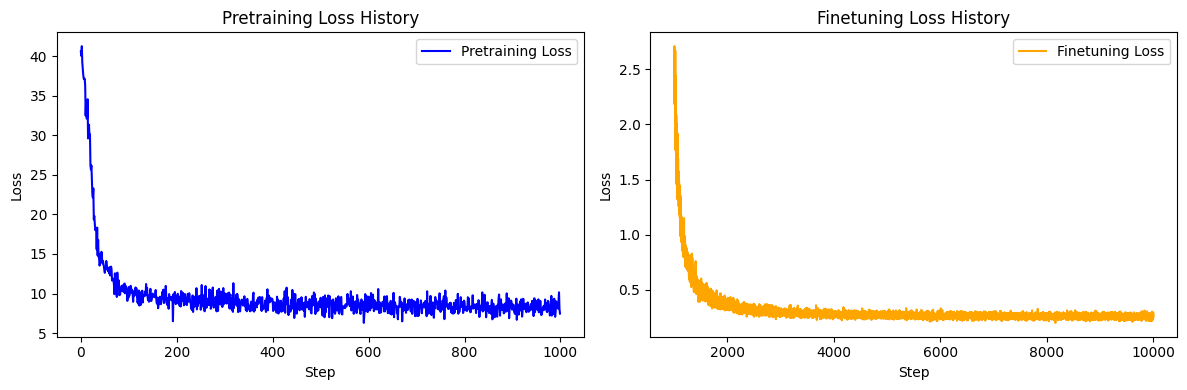

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(pretrain_loss, color='blue', label="Pretraining Loss")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[0].set_title("Pretraining Loss History")
axs[0].legend()

axs[1].plot(np.arange(len(pretrain_loss), len(pretrain_loss) + len(finetune_loss)),
            finetune_loss, color='orange', label="Finetuning Loss")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Loss")
axs[1].set_title("Finetuning Loss History")
axs[1].legend()

plt.tight_layout()
plt.show()

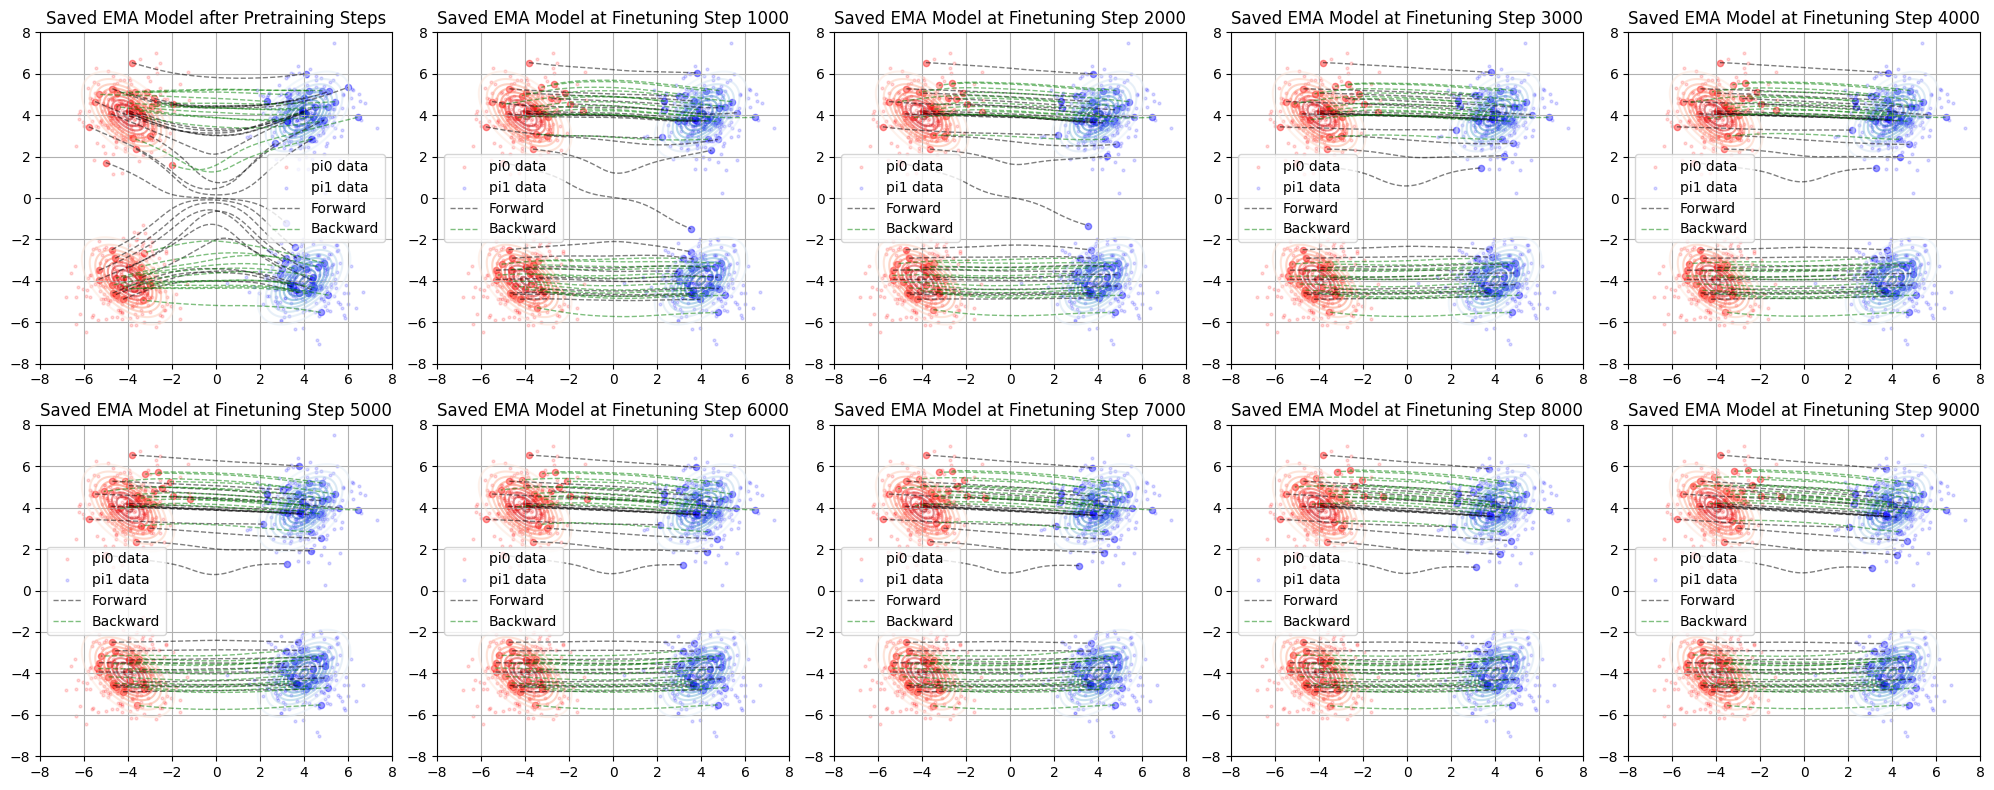

In [44]:
x0_pool, x1_pool = dl_pi0.dataset.x, dl_pi1.dataset.x
traj_dict = plot_saved_trajectories(saved_models, model, x0_pool, x1_pool, hidden_dim=hidden_dim, num_steps=100, eps=eps, num_traj=25, use_ema=True)
plot_trajectories_saved(traj_dict, x0_pool, x1_pool, nrows=2, save_freq=1000)